# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms including SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 


### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm?

* __c) short response:__ Briefly describe Dijkstra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ An example of a dataset is that is appropriate to represent as a graph is the LinkedIn network of all users and their connections to other users.  In this graph representation each node is a person and each vertex exists to represent whether or not two people are connected.  The vertices would be unweighted, since all connections have equal value and a weight of 1.  This graph can be undirected, as a connection between two nodes is assumed to be bi-directional, meaning that either node can contact the other if a connection exists. (Having a directed graph for this representation would mean 2 vertices that appear between any two nodes that have a connection, one going in each direction, which would appear redundant). The average "in-degree" of a node represents the number of vertices that point into the node.  In the case of LinkedIn, since all vertices represent bi-directional vertices, the average number of "in-degree" is then calculated by the average number of connections of all users of LinkedIn.  

> __b)__ Other than size and scale, graphs are uniquely challening to work with in the map-reduce paradigm because the fundamental units of a graph, consisting of nodes and edges, carry information about each other, and whether or not an objective can be met in a map-reduce algorithm depends heavily on the data structure used to represent the graph.  An inefficient data structure used for representation can mean an extremely costly algorithm or a result that is simply wrong.  For instance, we saw in the async that a FIFO queue (first in first out) is insfficient to calculate the SSSP (single source shortest path) of a weighted graph from one origin to all other nodes, and a priority queue involving the sorting of frontier path lengths must be used.  Representing graph data as either adjacency matrices versus adjacency lists also presents challenges.  A graph that is too sparse, meaning the number of edges is much smaller than the number of possible edges, may be better represented as an adjacency list in order to save on memory storage.  However, certain graph ooperations are easier on adjacency matrices than on adjacency lists, such as the computations that require knowledge of incoming links to each node. 

> __c)__ Dijkstra's algorithm is a sequential way to calculate the SSSP, the distance of each node to the single origin node, in a weighted graph.  The algorithm works as follows - starting with the source node, we process the frontier nodes (the most adjacent nodes) by placing them in a priority queue, where the queue is ordered by distances of each frontier queue from the source.  In the next step, we move to the nearest node, calculate and record its distance to the original source, then create a new priority queue of frontier nodes that are adjacent to the second node.  We then move to the next node in the priority queue, and repeat this process until we have visited all of the nodes in the graph.  At each node, we record its distance from the origin node, and because we move in a path of least weight each time, we guarantee that all of our calculations are the SSSP for that node.  The problem with Dijkstra's algorithm is that it must be done completely sequentially, meaning that we cannot move in parallel paths away from the source node to calculate the SSSP.  The key to Dijkstra's algorithm is that the decision to move at each node depends on which adjacent node has the smaller weight for the vertex. If parallel paths of traversal are allowed on the same graph, and say there are two paths that can reach the same node from the origin node, one of these paths is guaranteed to not be the SSSP.  Because parallelization may not guarantee that we always traverse the path of least distance to every node, this algorithm cannot be parallelized easily.  

> __d)__ Parallel breadth-first-search does allow us to find the SSSP using a parallelizable algorithm.  In this approach, we can processes the priority queue for all primary frontier nodes that are directly adjacent to the source in parallel, by creating a queue of their downstream adjacent nodes, and this process can be repeated for secondary frontier nodes, and tiertiary, and so on and so forth.  However, the cost of this algorithm comes from the situation when the reducer finds more than one path to the same node.  In the event that a shorter path is found to the same node, then we need to recompute the shortest path to each node downstream from this node, which could also be very costly. 

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="Lin-Dyer-graph-Q1.png" width="70%">

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.


### Q2 Student Answers:
> __a)__ Lin and Dyer describes a sparse graph as one where the number of actual edges is far less than the number of possible edges.  In this graph, the number of possible edges is 20, not counting self-edges, but the nubmer of actual edges is 9.  Since the number of actual edges is less than half of the number of possible edges, I would categorize this graph as sparse.  The sparsity/density inpacts the decision to represent a graph using either an adjacency matrix or adjacency list for computation.  For a graph of n notes, the adjacency matrix has a $O(n^2)$ space requirement, so it is often unwise to represent a very sparse graph as an adjacency matrix since the matrix will hold more 0 values than non-zero values and is thus not a good use of space. On the otherhand, for a very dense graph, the adjacency matrix and adjacency list may take up similar space. In addition, choosing to use an adjacency matrix versus adjacency list dependends on the type of graph operations in the algorithm objective, as an adjacency matrix is better for computation that requiring knowledge of incoming links while an adjacency list is only well-suited for operations involving knowledge of outgoing links. 

> __b)__ The graph that is created by the code below is directed.  The adjacency matrix for a directed graph only shows a non-zero value in position (i,j) if there is a directed edge going from node i to node j.  If this edge is unidirectional, meaning that there is no edge going from node j to node i, a 0 will be placed in the position (j,i) on the same adjacency matrix. In the adjacency matrix of a directed graph, every non-zero entry corresponds to one and only one existing edge.  

> For an undirected graph, there are two ways to represent the graph using an adjacency matrix. The first is to reach each edge as if there exists two edges, one going from node i to node j and the other going from node j to node i.  This creates an adjacency matrix that is symmetric across the diagonal where the non-zero value in position (i,j) and in position (j,i) corresponds to the same undirected edge going from node i to node j. 

> An undirected graph can also be represented as an upper triangular matrix, where only values above the main diagnonal could be non-zero while values below the main diagonal are all zeros.  In this representation, each non-zero value corresponds to one and only one undirected edge.  However, we only insert entries at position (i, j) for the existance of an edge between node i and node j, but only if i<j.  This would result in an upper triangular matrix.  

In [5]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

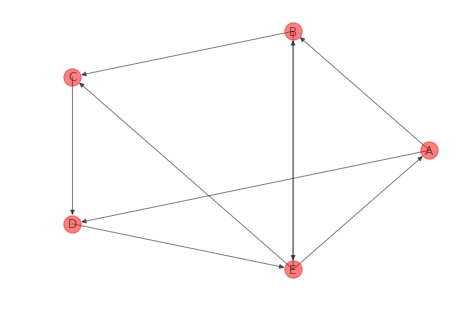

In [6]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [7]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for pair in graph['edges']:
        adj_matr.loc[pair[0],:][pair[1]] = 1

    ############### (END) YOUR CODE #################
    return adj_matr

In [8]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [9]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for pair in graph['edges']:
        adj_list[pair[0]].append(pair[1])
    
    ############### (END) YOUR CODE #################
    return adj_list

In [10]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.
    
    
    
### The Power Method Algorithm
```
initial approximation - random unit vector x0
# xInit = np.random.rand(transition_matrix.shape[1])
x1=Ax0
x2=AAx0=A2x0
x3=AAAx0=A3x0
...
until converges
```
For large powers of k, we will obrain a good approximation of the dominant eigenvector  
http://mlwiki.org/index.php/Power_Iteration

### Q3 Student Answers:
> __a)__  If we consider the webpages as nodes and the links between pages as edges, then the Page Rank is the probability distribution over nodes the graph, where each node is associated with a probability that represents the likelihood of traversing to that node.  In the context of a surfer who takes infinite steps, randomly traveling to each page through a link, the page rank is then a measure of how frequently a page would be encontered by this infinite surfer. 

> __b)__ The Markov property states that the conditional probability distribution of future states depends only on the present state and not on the sequence of events that led to the present state.  In the page rank algorithm, the present state is the page that the surfer is currently on and where the surfer goes next depends only on the links of the present page, but not the links on the previous page or the pages that the surfer has already viewed.  Hence, if we assume that the surfer has no ulterior motives but to travel from page to page using exising links available, then we can invoke the Markov property which states that the transitional probability to future states is memoryless of states before the current state. The Markov property is necessary to allow us to represent the page rank algorithm as recursive, which is what allows us to use the Power Method Algorithm to calculate the final steady state probabilities. 

> __c)__ In the page rank algorithm, the n states are the n nodes of the graph, where each node represents a page.  As stated in part (b), the path to the next node depends only on the current state, which is the current page that the surfer is viewing.  The transition matrix is the representation of the mechanism needed to travel from each node to every other node. The (i,j) entry in the transition matrix gives the probability of being in state j given that we are currently in state i, the probability of traveling from page i to page j.  Given that there are n states, which represents n nodes, the transition matrix must have dimensions nxn, where each entry corresponds to a possible edge.  Only actual edges in the graph however correspond to non-zero entries in the transition matrix. 

> __d)__ A right-stochastic matrix is a real, postive, square matrix where each row must sum to 1.  In order to create a right stocastic matrix from our adjacency matrix in part 2 to create the transition matrix, we must divide values in each row by the sum of values in that row.

> __e)__ According to the cell I ran below, it takes 6 iterations for convergence to take place.  After 6 iterations, the state vector is steady and remains unchanged. It appears that node E is the most highly ranked, with freqency of 0.316. This did not match my intuition, as I expected nodes with high in-degree to be highly ranked.  According to the graph, it looks like nodes B, D and E and the same number of in-degree, so I would have expected the 3 of them to share similar frequency values.  However, it was surprising to find that node E's page rank is twice that of node B.  This leads me to wonder if the intuition regarding in-degree breaks down when the number of nodes and edges is low. 

In [11]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [12]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = (TOY_ADJ_MATR.values.T/TOY_ADJ_MATR.values.sum(axis=1)).T # replace with your code

################ (END) YOUR CODE #################
print(transition_matrix)

[[0.         0.5        0.         0.5        0.        ]
 [0.         0.         0.5        0.         0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]]


In [13]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    for ix in range(nIter):    
        if verbose:
            print(f'Step {ix}:\n {tMatrix[0]}')
        tMatrix = tMatrix @ tMatrix #<-- preferred form of: tMatrix = tMatrix.dot(tMatrix)
    state_vector = tMatrix[0]
    ################ (END) YOUR CODE #################
    return state_vector

In [14]:
def eigenvalue(A, v):
    Av = A.dot(v)
    return v.dot(Av)

def power_iteration1(A):
    n, d = A.shape

    v = np.ones(d) / np.sqrt(d)
    ev = eigenvalue(A, v)
    count = 0
    
    while True:
        count += 1
        Av = A.dot(v)
        v_new = Av / np.linalg.norm(Av)

        ev_new = eigenvalue(A, v_new)
        
        if np.abs(ev - ev_new) < 0.00001:
            break
        
        v = v_new
        ev = ev_new

    return ev_new, v_new, count

In [ ]:
power_iteration1(np.transpose(transition_matrix))

In [ ]:
#!/usr/bin/python

import numpy as np

def power_iteration2(A, num_simulations):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    # b_k = np.array([1.0, 0, 0, 0, 0])
    b_k = np.random.rand(A.shape[1])

    for ix in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(np.transpose(A), b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm


        #print(f'Step {ix}:\n {b_k}')
    return b_k

power_iteration2(transition_matrix, 100)

In [ ]:
#transition_matrix
#[[0, 0.5, 0, 0.5, 0],[0, 0, 0.5, 0, 0.5],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1],[0.33333333, 0.33333333, 0.33333333, 0, 0]]

In [15]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
#xInit = np.random.rand(transition_matrix.shape[1])
#xInit = np.ones(transition_matrix.shape[1]) / np.sqrt(transition_matrix.shape[1])
#xInit = np.ones(transition_matrix.shape[1]) / (transition_matrix.shape[1])
print(xInit)
states = power_iteration(xInit, transition_matrix, 10, True)
#print(states)
#print("---")
#print(np.transpose(states))
#print("---")
#print(states[0])
#print("---")
#print("state vector")
#np.transpose(states) @ states[0]

[1. 0. 0. 0. 0.]
Step 0:
 [0.  0.5 0.  0.5 0. ]
Step 1:
 [0.   0.   0.25 0.   0.75]
Step 2:
 [0.    0.125 0.125 0.375 0.375]
Step 3:
 [0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
Step 4:
 [0.10386392 0.15674096 0.18360648 0.23753577 0.31825288]
Step 5:
 [0.10526656 0.15789725 0.18421194 0.23683994 0.3157843 ]
Step 6:
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 7:
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 8:
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 9:
 [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]


In [23]:
#Using the Rayleigh quotient, the dominant eigenvalue is:
def rayeigh_q(A,x):
    return np.dot(A.dot(states[0]),x)/np.dot(x,x)

In [35]:
eigen_V = power_iteration(xInit, transition_matrix, 10, False)[0]
rayeigh_q(transition_matrix,eigen_V)

array([[0.        , 0.5       , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        , 0.        ]])

In [ ]:
eigen_V2 = power_iteration2(transition_matrix, 100)
print(rayeigh_q(transition_matrix,eigen_V2))
print(eigenvalue(transition_matrix,eigen_V2))

In [ ]:
eigen_V1 = power_iteration1(transition_matrix)[1]
print(rayeigh_q(transition_matrix,eigen_V1))
print(eigenvalue(transition_matrix,eigen_V1))

Another good resource: http://ergodic.ugr.es/cphys/LECCIONES/FORTRAN/power_method.pdf

In [ ]:
sum(np.array([0.10526316, 0.15789474, 0.18421053, 0.23684211, 0.31578947]))

In [ ]:
sum(np.array([0.22153951, 0.33230927, 0.38769414, 0.4984639 , 0.66461853]))

In [ ]:
np.array([0.22153951, 0.33230927, 0.38769414, 0.4984639 , 0.66461853])/2.10462535

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

<img src="power-method.png"/>

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.


### Q4 Student Answers:
> __a)__ After the first iteration, we see only nan values for the state calculations after each step.  Convergence is never reached and we are unable to find steady state probabilities.  The underlying reason is that division by 0 results in nan values for the transition matrix calculation, since the row of the adjacency matrix that corresponds to the node E has all 0 values.  E is a dangling node and has no path to any other node, and thus results in a row with all 0s.  

> __b)__ The dangling node is E and it causes the problem described in (a) because it causes the Adjacency Matrix to have a row of 0.  When we calculate the right-stochastic transition matrix, there is no non-zero sum for the row that corresponds to transitions away from node E.  This results in nan values in the transition matrix, when we attempt to divide by 0, which will continue to spread to state calculations in the power method, leading to the inability for convergence. 

> One way to adjust the transition matrix for the dangling node is to allow the teleportation to any other node on the graph, with equal probability.  We can do this by replacing all the 0s in the row corresponding to E with 1s in the adjacency matrix, which would result in a row of all 1/5 values in the right stochastic matrix.  In doing so, we are allowing for traversals away from E to other nodes on the graph. 

> __c)__ For a graph to be irreducible, there must be a path from every node to every other node. Here, I assume that webgraph refers to the graph representation of pages in the world wide web.  The webgraph is not naturally irreducible if we define natural to be traversal using page links alone, that is without the ability to use the back button or the browser bar. If we only consider page links as vertices, then dangling nodes are inevitable since there are definitely pages which have no links on them and therefore no path to other nodes.  The existence of a dangling node means that there is no path from that node to any other node, and automatically violates the definition of irreducbility.  Therefore the webgraph is no irreducible.  

> __d)__ The webgraph is not naturally aperiodic. To be aperiodic, cycle lengths cannot have a common denominator greater than 1.  The existence of a cycle of length 1 in a graph along with the existence of cycle of any other length will automatically satisify the definition of aperiodicity, since the GCD of all cycle length will be 1.  There are definitely cycle lengths of 1 in the webgraph as there are pages with links to themselves.  

> __e)__ The modification to webgraph that guarantees aperiodicity and irreducbility is the teleportation matrix, which allows the traversal from any node to any other node.  In the surfer analogy, teleportation is the equivalent to using the search bar.  Even if the surfer is stuck on a page that represents a dangling node with no clickable links, he/she is able to traverse to any other page by typing a url into the url bar.  The ability to teleport away from a dangling node allows the webgraph to be irreducible and does not prevent the webgraph from being aperiodic, which it naturally was prior to the modification.


In [16]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

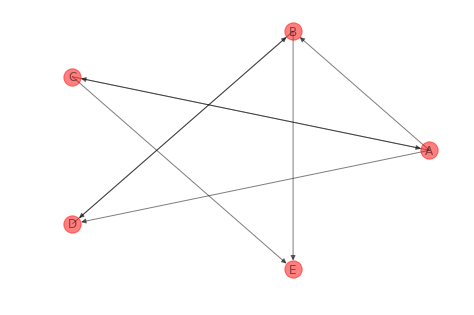

In [17]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [18]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY_ADJ_MATR2= get_adj_matr(TOY2_GRAPH)
print(TOY_ADJ_MATR2)
transition_matrix2 = (TOY_ADJ_MATR2.values.T/TOY_ADJ_MATR2.values.sum(axis=1)).T
print(transition_matrix2)
states = power_iteration(xInit, transition_matrix2, 10, True)
################ (END) YOUR CODE #################

   A  B  C  D  E
A  0  1  1  1  0
B  0  0  0  1  1
C  1  0  0  0  1
D  0  1  0  0  0
E  0  0  0  0  0
[[0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         0.5        0.5       ]
 [0.5        0.         0.         0.         0.5       ]
 [0.         1.         0.         0.         0.        ]
 [       nan        nan        nan        nan        nan]]
Step 0:
 [0.         0.33333333 0.33333333 0.33333333 0.        ]
Step 1:
 [nan nan nan nan nan]
Step 2:
 [nan nan nan nan nan]
Step 3:
 [nan nan nan nan nan]
Step 4:
 [nan nan nan nan nan]
Step 5:
 [nan nan nan nan nan]
Step 6:
 [nan nan nan nan nan]
Step 7:
 [nan nan nan nan nan]
Step 8:
 [nan nan nan nan nan]
Step 9:
 [nan nan nan nan nan]


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [19]:
# part a MODIFIED - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY_ADJ_MATR2_mod= get_adj_matr(TOY2_GRAPH)

#modify by inserting a 1 for all values in row E
TOY_ADJ_MATR2_mod.loc['E',:] = 1


transition_matrix2_mod = (TOY_ADJ_MATR2_mod.values.T/TOY_ADJ_MATR2_mod.values.sum(axis=1)).T
print(transition_matrix2_mod)
states = power_iteration(xInit, transition_matrix2_mod, 10, True)
################ (END) YOUR CODE #################

[[0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         0.5        0.5       ]
 [0.5        0.         0.         0.         0.5       ]
 [0.         1.         0.         0.         0.        ]
 [0.2        0.2        0.2        0.2        0.2       ]]
Step 0:
 [0.         0.33333333 0.33333333 0.33333333 0.        ]
Step 1:
 [0.16666667 0.33333333 0.         0.16666667 0.33333333]
Step 2:
 [0.10777778 0.35777778 0.06888889 0.21333333 0.25222222]
Step 3:
 [0.09313738 0.33675714 0.08246281 0.23848405 0.24915862]
Step 4:
 [0.09187882 0.32705008 0.08171045 0.24459614 0.25476452]
Step 5:
 [0.09183683 0.32653179 0.08163283 0.24489728 0.25510127]
Step 6:
 [0.09183673 0.32653061 0.08163265 0.24489796 0.25510204]
Step 7:
 [0.09183673 0.32653061 0.08163265 0.24489796 0.25510204]
Step 8:
 [0.09183673 0.32653061 0.08163265 0.24489796 0.25510204]
Step 9:
 [0.09183673 0.32653061 0.08163265 0.24489796 0.25510204]


# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [5]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [23]:
# download the test data set (RUN THIS CELL AS IS)
!wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [97]:
# take a look
!cat data/test_graph.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


### PLEASE NOTE, SECOND TEST FILE INCLUDED: 
In Slack, James provided a second test file.  I also include it in my work below.  The second test file has repeat adjacency nodes, which are better for testing.  However, the results displayed in 8 only match the original file

In [98]:
# take a look
!cat data/test_graph_2.txt

2	{'3': 1}
3	{'2': 2}
4	{'1': 1, '2': 1}
5	{'4': 3, '2': 1, '6': 1}
6	{'2': 1, '5': 2}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 2}


In [8]:
# download the main data set - this may take a little time (RUN THIS CELL AS IS)
!wget -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

--2019-07-15 21:17:23--  https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0
Resolving www.dropbox.com... 162.125.4.1, 2620:100:6019:1:ffff:ffff:a27d:401
Connecting to www.dropbox.com|162.125.4.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt [following]
--2019-07-15 21:17:23--  https://www.dropbox.com/sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbc6b8911d3d19667b512d5e739.dl.dropboxusercontent.com/cd/0/inline/AkxfyeeT9OY7azWkXIS-_6LaRD7WxNrAzp1BQ8cRUDCtpwYFiyzia3Wn998WlAGDeAcv66JBCFGJiUuqy6dHZLcy-2JY0lskDtrbMhXszPDe9w/file# [following]
--2019-07-15 21:17:23--  https://ucbc6b8911d3d19667b512d5e739.dl.dropboxusercontent.com/cd/0/inline/Akxfyee

In [42]:
# take a look (RUN THIS CELL AS IS)
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [43]:
# download the indexes (RUN THIS CELL AS IS)
!wget -q -O data/indices.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADSYhyRXbgebRDy6ALl6O1ca/wikipedia/indices.txt?dl=0

In [44]:
# take a look (RUN THIS CELL AS IS)
# You will need this file for the extra credit questions.
!head data/indices.txt

! $var = &quot;&quot;	1	1	0
! (CONFIG.SYS directive)	2	1	1
! (album)	3	12	17
! (disambiguation)	4	1	20
! -attention-	5	1	0
! Time Zone	6	1	0
!! (chess)	7	0	1
!! (disambiguation)	8	3	0
!!! (Chk Chk Chk)	9	1	0
!!! (album)	10	5	15


In [5]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('data/test_graph.txt')
testRDD2 = sc.textFile('data/test_graph_2.txt') #second test file included in all questions
indexRDD = sc.textFile('data/indices.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ Each row in the raw data has a key which uniquely identifies a wikipedia page and a corresponding value which is a dictionary.  The dictionary keys are unique identifiers for other wikipedia pages that are directly linked to the wikipedia page represented by the key.  In other words, each row key represents a node and the dictionary contains the adjacency list of that node as keys.  Each dictionary key also corresponds to a number, which represent the number of times a link to the adjacent node appears on the page that is represented by the row key.  

> __b)__ There are 5781290 records in the data set.  This is not the same as the number of nodes in the graph because this might only represent the number of nodes that have links to other pages.  This number may not be counting dangling nodes that do not have links to other pages and thus do not appear as row keys.  In order to find all nodes, we need to find all distinct keys in the union of all row keys and dictionary keys. 

> __d)__ The total number of nodes is 15192277.  The number of dangling nodes, assume that the raw data keys contain all non-dangling nodes, is the difference between the total number of nodes and the total number of raw data keys.  The number of dangling nodes is 15192277 - 5781290 = 9410987

In [24]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

5781290 data/wiki_graph.txt


In [100]:
#total number of nodes is the number of distinct keys in he union of all row keys and all dictionary keys
#mapper - emits key value pairs that are ids and count of 1.  the id list is the union of the row key and all dictionary keys
#use following helper function to parse raw data from file:

def parse_row(row):
    """takes each row of the raw data rdd
    returns key value pairs for every dictionary key in the value dictionary
    plus one key-value pair for the rdd key"""
    key, dictionary_text = row.split('\t')
    dictionary = ast.literal_eval(dictionary_text)
    
    #append each row key to the list of ids, where each id represents a nod
    id_list = list(dictionary.keys())
    id_list.append(key)
    
    return [(id, 1) for id in id_list]

# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############

    totalCount = dataRDD.flatMap(parse_row) \
             .reduceByKey(lambda x,y : x+y) \
             .count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [101]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.3646984100341797 seconds.
Total Nodes: 11


In [78]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 1683.37100315094 seconds.
Total Nodes: 15192277


# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ For a graph with |G| number of nodes, the page rank at node n is given by: $P(n)=\alpha\left(\dfrac{1}{|G|}\right)+(1-\alpha)\sum_{m\in L(n)}\dfrac{P(m)}{C(m)}$, where C(m) is the outdegree of every node m that links to node n. The first term in the equation describes the contribution from random jumps which depends on $\alpha$, the teleportation factor, and the inverse of the number of nodes.  The out-degree of previous nodes is important for the second term, which also depends on the dampening factor $(1-\alpha)$.  The second term describes how the page rank on node n actually depends on contributions from $L(n)$, or the set of all nodes that link to node n.  Each of the nodes m that link to node n contributes the amount $P(m)/C(m)$, or the page rank at node m divided by the out-degree C(m), to the page rank of node n.  

> __c)__ If a node's out-degree is 0, then the node has no outgoing vertices to other nodes in the graph, which makes it a dangling node.  In the page rank calculation, we can think of finding the page rank for each node as the steady state mass accumulation at each node.  The "loss" of mass from each node would contribute to the outbound nodes that emanante from each node.  However, since nodes with out-degree of 0 do not have outbound nodes, one way to handle their mass lost would be to redistribute it evenly across all of the nodes in the graph.  

In [102]:
# part a - write your Spark job here (compute average in-degree, etc)
# helper func
def parse(line):
    node, edges = line.split('\t')
    return (node, ast.literal_eval(edges))

def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    
    
    ############## YOUR CODE HERE ###############
    results = dataRDD.map(parse)\
                     .map(lambda x: (x[0], sum(list(x[1].values()))))\
                     .reduceByKey(lambda x,y : x+y)\
                     .cache()
    top = results.takeOrdered(10, key=lambda x: -x[1])
    avgDegree = results.map(lambda x: x[1]).sum()/results.count()
    sampledCounts = results.sample(withReplacement = False, fraction=n/results.count()).map(lambda x: x[1]).collect()
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

... completed job in 0.7993922233581543 seconds
Average out-degree:  1.7
Top 10 nodes (by out-degree:)
 [('5', 3), ('4', 2), ('8', 2), ('9', 2), ('6', 2), ('7', 2), ('10', 1), ('2', 1), ('3', 1), ('11', 1)]


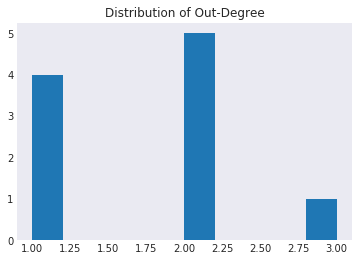

In [107]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

**The following shows results for second test file**

... completed job in 0.8473052978515625 seconds
Average out-degree:  1.7
Top 10 nodes (by out-degree:)
 [('5', 3), ('4', 2), ('8', 2), ('9', 2), ('6', 2), ('7', 2), ('10', 1), ('2', 1), ('3', 1), ('11', 1)]


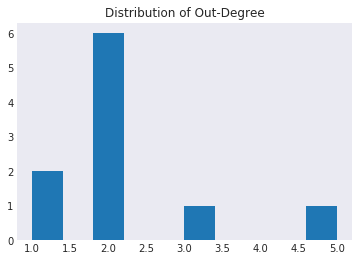

In [109]:
# part a - run your job on the second test file (RUN THIS CELL AS IS)
start = time.time()
test_results2 = count_degree(testRDD2,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results2[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

**Job on Full File**

... completed job in 1063.6398584842682 seconds
Average out-degree:  32.04181575392343
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]


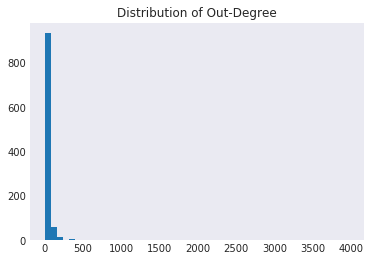

In [100]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
plt.show()

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) short response:__ What is $N$? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to $\frac{1}{N}$. (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute $N$ before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is the number of nodes in the graph.  In the analogy of the random surfer, say on the web, the surfer has the ability to "teleport" or jump to any webpage node by typing a url into the url search bar.  Initializing each node rank at 1/N then has the probablistic interpretation that the surfer has the same chance of starting on any of the nodes in the graph at the start of their journey. 

> __b)__ It is more efficient to compute N after initializing records for each of the dangling nodes.  N comes from finding the total number of nodes, but our intial data only contains rows for non-dangling nodes and their adjacency list, which means that we do not have rows for dangling nodes initially.  In order to find N using a Map Reduce job, we have to create rows in the RDD for the dangling nodes, then calculate the total number of rows to find N.  By creating rows for the dangling nodes, we are already in the process of initialzing records for them, so it is more efficient to compute N afterwards. We can first initialize rows for dangling records with a score of 0, then update the rows with 1/N once we have a row count. If we try to compute N before initializing records for dangling nodes, we would need two map reduce jobs, one that counts N and then a second one for row initialization, versus 1 map reduce job if we initialize the rows first.

In [6]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)

############## YOUR CODE HERE ###############
# write any helper functions here

def parse_row_reformat_output(row):
    """takes each row of the raw data rdd
    returns the following output (node, (score, adjacency list)) for every node ID, 
    
    This will be done for the row key node IDs and all of the dictionary key node IDs
    The initial score outputted by function will be 0 
        (and later updated to 1/N using a spark function, once we have all rows)
    
    For row keys, the output adjacency list is the dictionary keys
    For dictionary key, the output adjacency list will be empty from the initial mapper
        (their full adjacency list will be later accumulated in the reducer)
        
    The format of the adjacency lists from this function will be a string, 
        where node IDs are comma separated, 
        and nodes with multiple links are repeated
        (format is found to be more efficient than dictionary)
    """
    row_key, dictionary_text = row.split('\t')
    dictionary = ast.literal_eval(dictionary_text)
    
    #initialize string to contain adjacency list for row key
    row_key_adj_list = ''
    
    for node_id, value in dictionary.items():
        #each node id will be added to row key adjacency list
        #node id repeat count in the adjacency list is dicted by their dictionary value
        #node ids are separated by comma
        row_key_adj_list += (node_id+",")*value
        
        #initialize rdd row for dictionary node IDs (some might be dangling)
        #initial adjacency lists for dictionary node IDs are empty
        yield (node_id, (0, ""))
    
    #lastly, initialize row for row key node ID, with non-empty adjacency list
    yield (row_key, (0, row_key_adj_list[:-1]))


def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    
    # write your main Spark code here
    initialRdd = dataRDD.flatMap(parse_row_reformat_output)\
                      .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+','+y[1]) if y[1] != '' and x[1] != '' else (x[0]+y[0], x[1]+y[1]))\
                      .cache()
    N = initialRdd.count()
    graphRDD = initialRdd.map(lambda x: (x[0], (1/N, x[1][1])))
    ############## (END) YOUR CODE ##############
    
    return graphRDD

**The following shows job run on original test data with no repeat adjacent nodes**

In [7]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 2.6720263957977295 seconds.


[('1', (0.09090909090909091, '')),
 ('4', (0.09090909090909091, '1,2')),
 ('8', (0.09090909090909091, '2,5')),
 ('9', (0.09090909090909091, '2,5')),
 ('10', (0.09090909090909091, '5')),
 ('3', (0.09090909090909091, '2')),
 ('2', (0.09090909090909091, '3')),
 ('6', (0.09090909090909091, '2,5')),
 ('5', (0.09090909090909091, '4,2,6')),
 ('7', (0.09090909090909091, '2,5')),
 ('11', (0.09090909090909091, '5'))]

**The following shows job run on second test file data with repeat adjacent nodes**

In [8]:
# part c - run your Spark job on the SECOND test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph2 = initGraph(testRDD2).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph2

... test graph initialized in 0.6965446472167969 seconds.


[('1', (0.09090909090909091, '')),
 ('4', (0.09090909090909091, '1,2')),
 ('8', (0.09090909090909091, '2,5')),
 ('9', (0.09090909090909091, '2,5')),
 ('10', (0.09090909090909091, '5')),
 ('3', (0.09090909090909091, '2,2')),
 ('2', (0.09090909090909091, '3')),
 ('6', (0.09090909090909091, '2,5,5')),
 ('5', (0.09090909090909091, '4,4,4,2,6')),
 ('7', (0.09090909090909091, '2,5')),
 ('11', (0.09090909090909091, '5,5'))]

In [9]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 702.7489678859711 seconds


In [10]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('11777840', (6.582291778908455e-08, '6127245,5158607,5158607,757856,14772413,14803224,6905109,10666321,10666321,6007184,6007184,12469293,14773825,14773825,9343079,8892083,13077979,9285165,9285165,9285165,9285165,9285165,14978814,6420484,9789784,9789784,9789784,9789784,9789784,14482968,981395,981395,2921,15173803,12617777,7021832,7021832,2335603,14484050,9922389,11023778,2344940,6905766,9447742,9447742,6557458,1425342,9660994,9660994,11390944,11390944,11390944,14261593,14928135,14841606,14841606,14765621,12530354,2335868,13636570,13636570,13636570,13636570,13636570,13636570,2335876,9827642,15105458,9501013,9501013,11101298,9395391,9395391,6416278,15018227,8024321,11656072,11656072,11656072,11656072,11656072,5165182,6420027,7337035,7337035,14712897,14712897,10898196,15161507,535091,5595377,1725688,14183835,1402856,1398329,14670682,14210235,11696376,15087242,14900113,7316613,12071841,12048800,12048800,14624941,5789809,5789809,11497740,1149

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='PR-illustrated.png'>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

* __e)__ Please report your environment configuration. ie, # of machines, # of cores, Memory of each. As well as timings.
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ The term $\alpha * \frac{1}{|G|}$ represents the distribution of the teleportation factor across all nodes in the graph.  The teleportation factor is the probability that teleportation was the means the traversal to a node, rather than from an edge.  Since the method of teleportation is the same to any node from any other node, the page rank contribution due to teleportation for any node is the same.  Therefore, teleportation contibutes the amount $\alpha * \frac{1}{|G|}$ to every node's page rank calculation, which is the probability of teleportation divided by the total number of nodes, |G|.

> __b)__ In the equation above, m represents the total dangling mass.  The dangling mass in each iteration is equally distributed across all nodes, as it represents the mass loss from the dangling nodes.  For equal distibution, we divide by |G|, the number of nodes. 

> __c)__ Each iteration only redistributes the total mass that we started with, and does not add or delete mass.  Therefore, the total mass after each iteration should always match our initial total mass introduced to the algorithm, which is 1. 

> __e)__ Environment - The operating system is Mac OS X, version 10.14.3. There are 2 cores, 14 GB of Memory and 4 CPUs.

In [11]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [18]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
    
############## YOUR CODE HERE ###############
    
# write your helper functions here, 
# please document the purpose of each clearly 
# for reference, the master solution has 5 helper functions.

def dangling_mass_accumulator(row, dm):
    """
    adds row mass to the dangling mass accumulator only if itentified to be a dangling node
    dangling nodes are identified has having blank adjacency list
    must be called in spark job BEFORE mass redistribution of non-dangling nodes
    """
    node, payload = row
    
    if payload[1] == '':
        dm.add(payload[0])
        
    

def redistribution(row):
    """
    redistributes mass to outbound nodes for non-dangling nodes only
    
    for all nodes, output original rdd row with modification of mass = 0
        this ensures that all adjency lists are preserved for next iteration
        mass is set to 0 since redistribution or accumulation to dangling node mass has already occured
    """
    node, payload = row
    
    #if not dangling
    if payload[1] != '':
        #get adjacency list from string
        adj_list = payload[1].split(',')
        #calculate out-degree distribution which is current mass divided by out-degree
        dist_mass = payload[0]/len(adj_list)
        
        for adj in adj_list:
            yield (adj, (dist_mass, ''))
        
    #output original row with 0 mass to ensure that node and adjacency list are used in next iteration
    #but set mass to 0 because mass has either been accumulated to dangling mass total or distributed to outlinks
    yield (node, (0, payload[1]))
    
def new_mass(row, dm, alpha, damping, N):
    """
    calculate the new mass of each node using equation 
    must be called after dangling mass accumulation, redistribution, and first reducing step
    """
    node, payload = row
    
    newMass = alpha/N + damping*(dm/N+payload[0])
    
    return (node, (newMass, payload[1]))

def total_mass_accumulator(row, tm):
    """
    calculates total mass at then end of an iteration
    """
    node, payload = row
    
    tm.add(payload[0])
        
        
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())

        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    #get row count first, as this will not change for future iterations
    N = graphInitRDD.count()
    
    for i in range(maxIter):
        
        #at the start of every iteration, initialize a new rdd from previous iteration result
        jobRDD = graphInitRDD.map(lambda x: x)
        
        #find dangling mass total and broadcast to be used in map function later
        jobRDD.foreach(lambda x: dangling_mass_accumulator(x,mmAccum))
        dm_total = sc.broadcast(mmAccum.value)
    
        #entire job for mass flow
        #first redistribution of non-dangling node masses to outlinks
        #followed by reducing by key for all node masses to calculate total from inlinks
        #followed by calculation of new mass taking into consideration teleportation and damping factors
        #reassign result to graphInitRdd for next iteration
        graphInitRDD = jobRDD.flatMap(redistribution)\
                    .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+','+y[1]) if y[1] != '' and x[1] != '' else (x[0]+y[0], x[1]+y[1]))\
                    .map(lambda x: new_mass(x, dm_total.value, a.value, d.value, N))\
                    .cache()
        jobRDD.foreach(lambda x: total_mass_accumulator(x,totAccum))
        
        
        #if verbose is on, print total mass for check and the current RDD result
        if verbose == True:
            #print total mass for sanity check
            print('\nTotal Mass at the end of iteration '+str(i+1)+";", totAccum.value)
            #print dangling mass for sanity check
            #print('Dangling Mass at the end of iteration '+str(i+1)+";", mmAccum.value)
            #current mass distribution
            #print('Current mass distribution is:')
            #print(graphInitRDD.collect())
        
        #set accumulators to 0 before next iteration
        mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        
    #get steadyStateRDD after iterations complete
    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0]))
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

**The following shows final result for page rank job on original test file, no repeate adjacent nodes.  This matches provided output**

In [15]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'\n...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])


Total Mass at the end of iteration 1; 1.0
Dangling Mass at the end of iteration 1; 0.09090909090909091
Current mass distribution is:
[('1', (0.059297520661157024, '')), ('4', (0.046418732782369146, '1,2')), ('8', (0.02066115702479339, '2,5')), ('9', (0.02066115702479339, '2,5')), ('10', (0.02066115702479339, '5')), ('2', (0.3168732782369146, '3')), ('5', (0.32975206611570246, '4,2,6')), ('3', (0.09793388429752066, '2')), ('6', (0.046418732782369146, '2,5')), ('7', (0.02066115702479339, '2,5')), ('11', (0.02066115702479339, '5'))]

Total Mass at the end of iteration 2; 1.0000000000000002
Dangling Mass at the end of iteration 2; 0.059297520661157024
Current mass distribution is:
[('1', (0.03794640621086902, '')), ('4', (0.11164819684447784, '1,2')), ('8', (0.018218444778362132, '2,5')), ('9', (0.018218444778362132, '2,5')), ('10', (0.018218444778362132, '5')), ('2', (0.26069089656899574, '3')), ('5', (0.09941334835962935, '4,2,6')), ('3', (0.2875607312797395, '2')), ('6', (0.11164819684

[('2', 0.38031552249156747),
 ('3', 0.3469932932917439),
 ('5', 0.08088637369406641),
 ('4', 0.039087602168414746),
 ('6', 0.039087602168414746),
 ('1', 0.032781877034008526),
 ('8', 0.01616954583035677),
 ('9', 0.01616954583035677),
 ('10', 0.01616954583035677),
 ('7', 0.01616954583035677),
 ('11', 0.01616954583035677)]

__`expected results for the test graph:`__
```
(2, 0.3803155224915675)
(3, 0.3469932932917439)
(5, 0.08088637369406641)
(4, 0.039087602168414746)
(6, 0.039087602168414746)
(1, 0.032781877034008526)
(8, 0.01616954583035677)
(10, 0.01616954583035677)
(7, 0.01616954583035677)
(9, 0.01616954583035677)
(11, 0.01616954583035677)
```

**I also run the job on the second test file with repeat adjacency nodes, if needed**

In [19]:
# part d - run PageRank on the second test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD2 = initGraph(testRDD2)
start = time.time()
test_results = runPageRank(testGraphRDD2, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])


Total Mass at the end of iteration 1; 1.0

Total Mass at the end of iteration 2; 1.0

Total Mass at the end of iteration 3; 0.9999999999999999

Total Mass at the end of iteration 4; 0.9999999999999998

Total Mass at the end of iteration 5; 0.9999999999999998

Total Mass at the end of iteration 6; 1.0

Total Mass at the end of iteration 7; 0.9999999999999998

Total Mass at the end of iteration 8; 0.9999999999999999

Total Mass at the end of iteration 9; 0.9999999999999998

Total Mass at the end of iteration 10; 0.9999999999999998

Total Mass at the end of iteration 11; 0.9999999999999997

Total Mass at the end of iteration 12; 0.9999999999999997

Total Mass at the end of iteration 13; 0.9999999999999998

Total Mass at the end of iteration 14; 0.9999999999999998

Total Mass at the end of iteration 15; 0.9999999999999996

Total Mass at the end of iteration 16; 0.9999999999999996

Total Mass at the end of iteration 17; 0.9999999999999996

Total Mass at the end of iteration 18; 0.999999999

[('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('11', 0.01692511778009981)]

In [20]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])


Total Mass at the end of iteration 1; 1.0000000000066371

Total Mass at the end of iteration 2; 1.0000000000011255

Total Mass at the end of iteration 3; 1.0000000000007871

Total Mass at the end of iteration 4; 1.0000000000007772

Total Mass at the end of iteration 5; 1.000000000001333

Total Mass at the end of iteration 6; 1.0000000000005271

Total Mass at the end of iteration 7; 1.0000000000009808

Total Mass at the end of iteration 8; 1.0000000000002105

Total Mass at the end of iteration 9; 1.0000000000008313

Total Mass at the end of iteration 10; 1.000000000000832
...trained 10 iterations in 8962.678350925446 seconds.
Top 20 ranked nodes:


[('13455888', 0.0015447247129815062),
 ('4695850', 0.0006710240718898991),
 ('5051368', 0.0005983856809740987),
 ('1184351', 0.0005982073536461832),
 ('2437837', 0.0004624928928935398),
 ('6076759', 0.0004550940064139835),
 ('4196067', 0.0004423778888367477),
 ('13425865', 0.00044155351714293),
 ('6172466', 0.00042240020018403484),
 ('1384888', 0.00040128956040700394),
 ('6113490', 0.00039578924771769826),
 ('14112583', 0.00039438472837498534),
 ('7902219', 0.00037009878473527217),
 ('10390714', 0.00036502649643239867),
 ('12836211', 0.0003619948863109962),
 ('6237129', 0.0003519555847621222),
 ('6416278', 0.0003486623564522739),
 ('13432150', 0.0003393651063737706),
 ('1516699', 0.00033297500286206026),
 ('7990491', 0.0003076090626583142)]

# Extra Credit
(The combined extra credit points amount to approximately 5 percentage points on your final grade.)

## EC 1 - 5pts
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs. 

* __a)__ Join this dataset with your top 20 results.   
* __b)__ Print the results

Expected results:

<img src="joinedWithTitles.png" width="50%">

In [ ]:
# part a 
joinedWithNames = None
################# YOUR CODE ##################

############## (END) YOUR CODE ###############

In [ ]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## EC 2 - 30pts

GraphFrames is a graph library which is built on top of the Spark DataFrames API. 

* __a)__ Using the same dataset, run the graphframes implementation of pagerank. 
* __b)__ Join the top 20 results with indices.txt and display in the same format as above.
* __c)__ Compare your results with the results from graphframes. 

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [ ]:
# Create a GraphFrame
from graphframes import *

################# YOUR CODE ##################

############## (END) YOUR CODE ###############

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.